Code to classify the floats into clusters using Nick's pre-defined clusters as the labeled data

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import sys
sys.path.append('../')
from utils.get_season import get_season
from xgboost import XGBClassifier

In [2]:
#read in data
date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv("../../data/satData_clusters.csv",parse_dates=['date'], date_parser=date_parser)
df.head()

,float,cluster,cycleNumber,date,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP,LT_SAT_SST_SD,LT_SAT_SST_MED,LT_SAT_CHL_SD,LT_SAT_CHL_MED,LT_SAT_BBP_SD,LT_SAT_BBP_MED
0,1902303,NaN,1,2021-05-06 02:03:16,49.236,-14.742,-4539.0,12.451869,0.435093,0.003340,2.156995,12.796509,0.253809,0.401662,0.000819,0.002213
1,1902303,NaN,2,2021-05-06 19:32:57,49.096,-14.617,-4612.0,12.466026,0.782180,0.003081,2.214400,12.673785,0.222806,0.398969,0.000793,0.002114
2,1902303,NaN,3,2021-05-07 20:05:38,48.914,-14.606,-4700.0,12.424099,0.458020,0.003185,2.211703,12.808284,0.279028,0.428079,0.000752,0.002105
3,1902303,NaN,4,2021-05-08 22:42:52,48.794,-14.689,-4753.0,12.374519,0.378064,0.001767,2.200517,13.010804,0.278832,0.422287,0.000679,0.002087
4,1902303,NaN,5,2021-05-09 20:29:00,48.719,-14.795,-4765.0,12.204494,0.411479,0.001677,2.232417,12.931680,0.334429,0.419105,0.000776,0.002090


In [3]:
#Create the unique ID for each float/cycle - these will be the unique observations
df['float_cycle'] = df['float'].map(str)+'_'+df['cycleNumber'].map(str)

In [4]:
# add a column for the day of the year in radians
df.insert(loc=list(df.columns).index('date')+1, column='day_of_year_rad', value=[(int(d.strftime('%j'))*np.pi)/182.625 for d in df['date']])

In [5]:
df.head()

,float,cluster,cycleNumber,date,day_of_year_rad,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP,LT_SAT_SST_SD,LT_SAT_SST_MED,LT_SAT_CHL_SD,LT_SAT_CHL_MED,LT_SAT_BBP_SD,LT_SAT_BBP_MED,float_cycle
0,1902303,NaN,1,2021-05-06 02:03:16,2.167505,49.236,-14.742,-4539.0,12.451869,0.435093,0.003340,2.156995,12.796509,0.253809,0.401662,0.000819,0.002213,1902303_1
1,1902303,NaN,2,2021-05-06 19:32:57,2.167505,49.096,-14.617,-4612.0,12.466026,0.782180,0.003081,2.214400,12.673785,0.222806,0.398969,0.000793,0.002114,1902303_2
2,1902303,NaN,3,2021-05-07 20:05:38,2.184708,48.914,-14.606,-4700.0,12.424099,0.458020,0.003185,2.211703,12.808284,0.279028,0.428079,0.000752,0.002105,1902303_3
3,1902303,NaN,4,2021-05-08 22:42:52,2.201910,48.794,-14.689,-4753.0,12.374519,0.378064,0.001767,2.200517,13.010804,0.278832,0.422287,0.000679,0.002087,1902303_4
4,1902303,NaN,5,2021-05-09 20:29:00,2.219113,48.719,-14.795,-4765.0,12.204494,0.411479,0.001677,2.232417,12.931680,0.334429,0.419105,0.000776,0.002090,1902303_5


In [6]:
#Columns of interest: 'float', 'cycleNumber', 'latitude', 'longitude', 'date', 'sat_chl', 'sat_sst', 'sat_pic', 'sat_par', 'sat_aph_443'
#Read in dataframe with satellite data
zf = zipfile.ZipFile("../../data/float_loc_data_new_vars.csv.zip") 
sat_df = pd.read_csv(zf.open('float_loc_data_new_vars2.csv'))
sat_df.head()

,float,latitude,longitude,cycleNumber,date,PRES,PSAL,TEMP,BBP700,CHLA,...,sat_pic,sat_Rrs_678,sat_aph_443,sat_par,sat_angstrom,sat_bb_678,sat_adg_443,sat_aot_869,sat_adg_s,sat_bbp_s
0,1902303,49.236,-14.742,1,2021-05-06 02:03:16,3,35.539001,12.378333,0.001788,0.695875,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
1,1902303,49.236,-14.742,1,2021-05-06 02:03:16,4,35.539001,12.378333,0.001788,0.695875,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
2,1902303,49.236,-14.742,1,2021-05-06 02:03:16,6,35.539001,12.378667,0.001788,0.696499,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
3,1902303,49.236,-14.742,1,2021-05-06 02:03:16,8,35.539001,12.379000,0.001789,0.716489,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
4,1902303,49.236,-14.742,1,2021-05-06 02:03:16,10,35.539001,12.379000,0.001790,0.715552,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373


In [7]:
## keep only columns of interest:
sat_df = sat_df[['float', 'cycleNumber', 'sat_chl','sat_sst', 'sat_poc','sat_bbp_443', 'sat_pic', 'sat_aph_443', 'sat_par','sat_bb_678']].drop_duplicates()

In [8]:
#Create the unique ID for each float/cycle - these will be the unique observations
sat_df['float_cycle'] = sat_df['float'].map(str)+'_'+sat_df['cycleNumber'].map(str)
sat_df = sat_df.drop(['float','cycleNumber'], axis=1)

In [9]:
#Join the cluster data with the satellite data on float/cycle
cluster_df = df.merge(sat_df, on='float_cycle', how='left')
cluster_df.head()

,float,cluster,cycleNumber,date,day_of_year_rad,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,...,LT_SAT_BBP_MED,float_cycle,sat_chl,sat_sst,sat_poc,sat_bbp_443,sat_pic,sat_aph_443,sat_par,sat_bb_678
0,1902303,NaN,1,2021-05-06 02:03:16,2.167505,49.236,-14.742,-4539.0,12.451869,0.435093,...,0.002213,1902303_1,0.370203,12.610000,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995
1,1902303,NaN,2,2021-05-06 19:32:57,2.167505,49.096,-14.617,-4612.0,12.466026,0.782180,...,0.002114,1902303_2,0.553922,12.815000,109.399902,0.003030,0.000188,0.0405,52.312000,0.001980
2,1902303,NaN,3,2021-05-07 20:05:38,2.184708,48.914,-14.606,-4700.0,12.424099,0.458020,...,0.002105,1902303_3,0.506032,12.480000,107.399902,0.003015,0.000192,0.0395,16.085999,0.001950
3,1902303,NaN,4,2021-05-08 22:42:52,2.201910,48.794,-14.689,-4753.0,12.374519,0.378064,...,0.002087,1902303_4,0.694757,12.639999,125.000000,0.003025,0.000136,0.0486,54.299999,0.002040
4,1902303,NaN,5,2021-05-09 20:29:00,2.219113,48.719,-14.795,-4765.0,12.204494,0.411479,...,0.002090,1902303_5,0.509723,12.375000,111.600098,0.002080,0.000080,0.0231,55.393997,0.001475


In [10]:
#Double check that floats may belong to multiple clusters (different cycles affect this)
test = cluster_df[['float','cluster']].drop_duplicates().dropna()
print(len(test), ' unique float/cluster combos')
print(len(test['float'].unique()), ' unique floats')

234  unique float/cluster combos
204  unique floats


In [11]:
# Data preprocessing - change the date to a datetime index
cluster_df['month'] = cluster_df['date'].apply(lambda x: x.month)

In [12]:
#Capture seasonality in the data
month_seasons_dict = {
    1: [1, 3],
    2: [1, 3],
    3: [2, 4],
    4: [2, 4],
    5: [2, 4],
    6: [3, 1],
    7: [3, 1],
    8: [3, 1],
    9: [4, 2],
    10: [4, 2],
    11: [4,2],
    12: [1, 3],
}
#Dictionary for our own understanding of the seasons mapping
seasons_dict = {
    1: 'Winter',
    2: 'Spring',
    3: 'Summer',
    4: 'Fall'
}

In [13]:
#Add column for seasonality
cluster_df['season'] = cluster_df.apply(lambda x: get_season(x, month_seasons_dict), axis=1)

In [14]:
cluster_df.head()

,float,cluster,cycleNumber,date,day_of_year_rad,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,...,sat_chl,sat_sst,sat_poc,sat_bbp_443,sat_pic,sat_aph_443,sat_par,sat_bb_678,month,season
0,1902303,NaN,1,2021-05-06 02:03:16,2.167505,49.236,-14.742,-4539.0,12.451869,0.435093,...,0.370203,12.610000,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2
1,1902303,NaN,2,2021-05-06 19:32:57,2.167505,49.096,-14.617,-4612.0,12.466026,0.782180,...,0.553922,12.815000,109.399902,0.003030,0.000188,0.0405,52.312000,0.001980,5,2
2,1902303,NaN,3,2021-05-07 20:05:38,2.184708,48.914,-14.606,-4700.0,12.424099,0.458020,...,0.506032,12.480000,107.399902,0.003015,0.000192,0.0395,16.085999,0.001950,5,2
3,1902303,NaN,4,2021-05-08 22:42:52,2.201910,48.794,-14.689,-4753.0,12.374519,0.378064,...,0.694757,12.639999,125.000000,0.003025,0.000136,0.0486,54.299999,0.002040,5,2
4,1902303,NaN,5,2021-05-09 20:29:00,2.219113,48.719,-14.795,-4765.0,12.204494,0.411479,...,0.509723,12.375000,111.600098,0.002080,0.000080,0.0231,55.393997,0.001475,5,2


In [33]:
#Drop data not in our set: 
cluster_df = cluster_df.drop(['MO_SAT_SST', 'MO_SAT_CHL',
       'MO_SAT_BBP', 'LT_SAT_SST_SD', 'LT_SAT_SST_MED', 'LT_SAT_CHL_SD',
       'LT_SAT_CHL_MED', 'LT_SAT_BBP_SD', 'LT_SAT_BBP_MED'], axis=1)

Separate data into the train/test data and the new data for predictions

In [34]:
new_data = cluster_df[cluster_df['cluster'].isna()]
model_data = cluster_df[-cluster_df['cluster'].isna()]

In [35]:
#Add bins to stratify the data cut into train/test
model_data['lon_bin'] = pd.cut(model_data['longitude'],np.arange(-180,190,10))
model_data['lat_bin'] = pd.cut(model_data['latitude'],np.arange(-90,100,10))

/var/folders/8w/yzz7q0p146x4qrt7dwp0mhy40000gn/T/ipykernel_23935/3165825513.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['lon_bin'] = pd.cut(model_data['longitude'],np.arange(-180,190,10))
/var/folders/8w/yzz7q0p146x4qrt7dwp0mhy40000gn/T/ipykernel_23935/3165825513.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['lat_bin'] = pd.cut(model_data['latitude'],np.arange(-90,100,10))


In [36]:
#Sample 1 observation for each season/lat/lon for the test set
test_set = model_data.groupby(['lon_bin','lat_bin','season']).apply(lambda x: x.sample(1)).reset_index(drop=True)
#Remove these observations from the train data
train_set = model_data[-model_data['float_cycle'].isin(test_set['float_cycle'].unique())]
print('test size: ',round(len(test_set)/(len(test_set)+len(train_set))*100,0),'%')
#Now pull from train_set and sample 18% of remaining obeservations for each season/lat/lon
test_set_new = train_set.groupby(['lon_bin','lat_bin','season']).apply(lambda x: x.sample(frac=.17)).reset_index(drop=True)
test_set = pd.concat([test_set,test_set_new])
#Remove these observations from the train data
train_set = train_set[-train_set['float_cycle'].isin(test_set['float_cycle'].unique())]
print('test size: ',round(len(test_set)/(len(test_set)+len(train_set))*100,0),'%')


test size:  3.0 %
test size:  20.0 %


In [37]:
#Are all clusters in both train and test?
sorted(test_set['cluster'].unique()) == sorted(train_set['cluster'].unique())

True

In [38]:
train_set['cluster'].value_counts()

LCB     7120
HCB     3706
SDCM    3015
EQ      2736
PDCM    2479
AR       546
Name: cluster, dtype: int64

In [39]:
test_set.head()

,float,cluster,cycleNumber,date,day_of_year_rad,latitude,longitude,elevation,float_cycle,sat_chl,...,sat_poc,sat_bbp_443,sat_pic,sat_aph_443,sat_par,sat_bb_678,month,season,lon_bin,lat_bin
0,5905099,HCB,13,2017-08-15 14:16:48,3.904950,-60.797000,-176.957000,-4059.0,5905099_13,NaN,...,NaN,NaN,NaN,NaN,3.613998,NaN,8,1,"(-180, -170]","(-70, -60]"
1,5904104,LCB,198,2016-09-20 19:31:05,4.541440,-63.216000,-178.031000,-3393.0,5904104_198,0.189993,...,53.0,0.001195,0.00001,0.0153,13.247997,0.000915,9,2,"(-180, -170]","(-70, -60]"
2,5904104,LCB,211,2016-12-23 11:56:59,6.158468,-62.554000,-172.114000,-3458.0,5904104_211,0.190683,...,67.0,0.002845,0.00021,0.0173,35.711998,0.001695,12,3,"(-180, -170]","(-70, -60]"
3,5904688,HCB,145,2020-04-02 11:12:14,1.599825,-63.200602,-174.737587,-3403.0,5904688_145,NaN,...,NaN,NaN,NaN,NaN,4.875996,NaN,4,4,"(-180, -170]","(-70, -60]"
4,5905373,LCB,88,2020-06-21 06:36:29,2.976019,-58.479000,-176.159000,-4519.0,5905373_88,NaN,...,NaN,NaN,NaN,NaN,1.569996,NaN,6,1,"(-180, -170]","(-60, -50]"


## One against rest models

In [40]:
one_hot_train = pd.get_dummies(train_set['cluster'])
train_set = pd.concat([train_set, one_hot_train], axis=1)
train_set.head()

,float,cluster,cycleNumber,date,day_of_year_rad,latitude,longitude,elevation,float_cycle,sat_chl,...,month,season,lon_bin,lat_bin,AR,EQ,HCB,LCB,PDCM,SDCM
239,2902086,EQ,3,2013-01-01 03:49:00,0.017202,12.226748,88.674653,-3143.0,2902086_3,0.151244,...,1,1,"(80, 90]","(10, 20]",0,1,0,0,0,0
240,2902086,EQ,4,2013-01-02 03:28:00,0.034405,12.255253,88.660667,-3137.0,2902086_4,0.148740,...,1,1,"(80, 90]","(10, 20]",0,1,0,0,0,0
241,2902086,EQ,5,2013-01-03 03:21:00,0.051607,12.279345,88.662178,-3133.0,2902086_5,0.148740,...,1,1,"(80, 90]","(10, 20]",0,1,0,0,0,0
242,2902086,EQ,6,2013-01-04 03:30:00,0.068810,12.305605,88.652755,-3129.0,2902086_6,0.143393,...,1,1,"(80, 90]","(10, 20]",0,1,0,0,0,0
243,2902086,EQ,7,2013-01-05 03:27:00,0.086012,12.321588,88.645502,-3128.0,2902086_7,0.156987,...,1,1,"(80, 90]","(10, 20]",0,1,0,0,0,0


In [41]:
one_hot_test = pd.get_dummies(test_set['cluster'])
test_set = pd.concat([test_set, one_hot_test], axis=1)
test_set.head()

,float,cluster,cycleNumber,date,day_of_year_rad,latitude,longitude,elevation,float_cycle,sat_chl,...,month,season,lon_bin,lat_bin,AR,EQ,HCB,LCB,PDCM,SDCM
0,5905099,HCB,13,2017-08-15 14:16:48,3.904950,-60.797000,-176.957000,-4059.0,5905099_13,NaN,...,8,1,"(-180, -170]","(-70, -60]",0,0,1,0,0,0
1,5904104,LCB,198,2016-09-20 19:31:05,4.541440,-63.216000,-178.031000,-3393.0,5904104_198,0.189993,...,9,2,"(-180, -170]","(-70, -60]",0,0,0,1,0,0
2,5904104,LCB,211,2016-12-23 11:56:59,6.158468,-62.554000,-172.114000,-3458.0,5904104_211,0.190683,...,12,3,"(-180, -170]","(-70, -60]",0,0,0,1,0,0
3,5904688,HCB,145,2020-04-02 11:12:14,1.599825,-63.200602,-174.737587,-3403.0,5904688_145,NaN,...,4,4,"(-180, -170]","(-70, -60]",0,0,1,0,0,0
4,5905373,LCB,88,2020-06-21 06:36:29,2.976019,-58.479000,-176.159000,-4519.0,5905373_88,NaN,...,6,1,"(-180, -170]","(-60, -50]",0,0,0,1,0,0


In [42]:
cluster_names = train_set['cluster'].unique()
cluster_names

array(['EQ', 'AR', 'LCB', 'PDCM', 'SDCM', 'HCB'], dtype=object)

In [43]:
#Remove unnecessary columns:
drop_cols = ['float','cluster','cycleNumber','date','float_cycle','lon_bin','lat_bin']
train_set = train_set.drop(drop_cols, axis=1)
test_set = test_set.drop(drop_cols, axis=1)

### LCB model

In [59]:
cluster_name = 'LCB'
#Drop columns with cluster info, first make cluster of interest into y data
y_train, y_test = train_set[[cluster_name]], test_set[[cluster_name]]
x_train, x_test = train_set.drop(cluster_names, axis=1), test_set.drop(cluster_names, axis=1)

In [60]:
xgb = XGBClassifier()
xgb.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [63]:
y_hat = xgb.predict(x_test)

accuracy: 0.974592026440818
precision: 0.9580193756727664
recall: 0.9753424657534246
roc/auc: 0.9747401983939538
confusion_matrix percents by row:
 [[0.97413793 0.02586207]
 [0.02465753 0.97534247]]


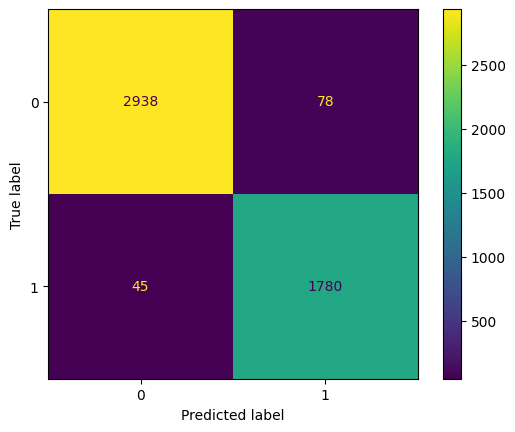

In [64]:
print('accuracy:', accuracy_score(y_test, y_hat))
print('precision:', precision_score(y_test, y_hat))
print('recall:', recall_score(y_test, y_hat))
print('roc/auc:', roc_auc_score(y_test, y_hat))
cm = confusion_matrix(y_test, y_hat, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('confusion_matrix percents by row:\n', cm)



In [65]:
y_hat_prob = xgb.predict_proba(x_test)

In [66]:
y_hat_prob[0:10]

array([[0.9628304 , 0.0371696 ],
       [0.09705913, 0.90294087],
       [0.15765417, 0.84234583],
       [0.38069755, 0.61930245],
       [0.07789212, 0.9221079 ],
       [0.9118675 , 0.08813251],
       [0.01315182, 0.9868482 ],
       [0.761905  , 0.238095  ],
       [0.02073663, 0.97926337],
       [0.00752032, 0.9924797 ]], dtype=float32)

### AR Model

In [48]:
cluster_name = 'AR'
#Drop columns with cluster info, first make cluster of interest into y data
y_train, y_test = train_set[[cluster_name]], test_set[[cluster_name]]
x_train, x_test = train_set.drop(cluster_names, axis=1), test_set.drop(cluster_names, axis=1)

In [49]:
xgb = XGBClassifier()
xgb.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [50]:
y_hat = xgb.predict(x_test)

accuracy: 0.9995868622185499
precision: 0.9924242424242424
recall: 0.9924242424242424
roc/auc: 0.9961059415561433
confusion_matrix percents by row:
 [[9.99787641e-01 2.12359312e-04]
 [7.57575758e-03 9.92424242e-01]]


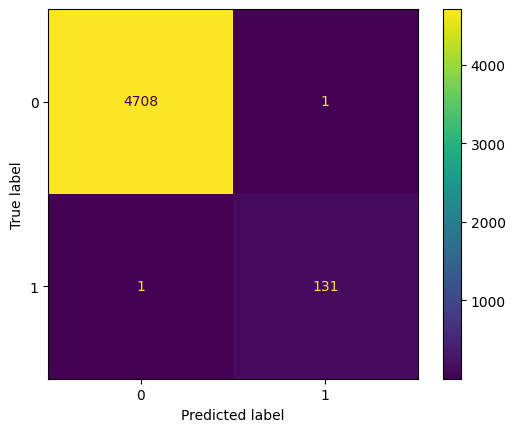

In [51]:
print('accuracy:', accuracy_score(y_test, y_hat))
print('precision:', precision_score(y_test, y_hat))
print('recall:', recall_score(y_test, y_hat))
print('roc/auc:', roc_auc_score(y_test, y_hat))
cm = confusion_matrix(y_test, y_hat, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('confusion_matrix percents by row:\n', cm)



### HCB Model

In [52]:
cluster_name = 'HCB'
#Drop columns with cluster info, first make cluster of interest into y data
y_train, y_test = train_set[[cluster_name]], test_set[[cluster_name]]
x_train, x_test = train_set.drop(cluster_names, axis=1), test_set.drop(cluster_names, axis=1)

In [53]:
xgb = XGBClassifier()
xgb.fit(x_train,y_train)
y_hat = xgb.predict(x_test)

accuracy: 0.9787234042553191
precision: 0.9579067121729238
recall: 0.9273127753303965
roc/auc: 0.9589525992085494
confusion_matrix percents by row:
 [[0.99059242 0.00940758]
 [0.07268722 0.92731278]]


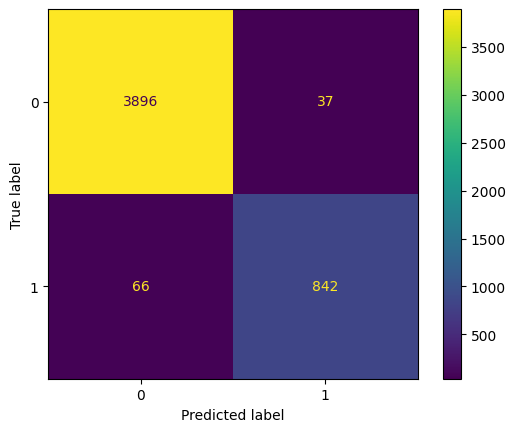

In [54]:
print('accuracy:', accuracy_score(y_test, y_hat))
print('precision:', precision_score(y_test, y_hat))
print('recall:', recall_score(y_test, y_hat))
print('roc/auc:', roc_auc_score(y_test, y_hat))
cm = confusion_matrix(y_test, y_hat, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('confusion_matrix percents by row:\n', cm)

In [55]:
data = {'feature_importance':xgb.feature_importances_,'feature_names':x_train.columns}
fi_df = pd.DataFrame(data)
fi_df = fi_df.sort_values(by='feature_importance', ascending=False)
fi_df

,feature_importance,feature_names
1,0.472015,latitude
2,0.105635,longitude
5,0.095974,sat_sst
3,0.061142,elevation
6,0.054927,sat_poc
9,0.035865,sat_aph_443
13,0.033721,season
0,0.033217,day_of_year_rad
8,0.021761,sat_pic
10,0.020919,sat_par
